In [1]:
# pip install yahoo_fin --upgrade

In [2]:
# !pip install --upgrade pandas-datareader

# Bitcoin Price Time Series Analysis and Prediction

This is a group project that I did for a time series analysis course at Columbia University. This is inspired by a time series analysis project that I found on GitHub. This notebook performs time series analysis on Bitcoin (BTC-USD) price data to understand historical trends and patterns. The analysis includes data preprocessing, statistical testing, and time series modeling.

## Project Overview
- Data Source: Yahoo Finance BTC-USD historical data
- Time Period: October 31, 2016 - October 31, 2022
- Analysis Type: Time Series Analysis

## Analysis Steps
1. Data Collection
2. Data Preprocessing
3. Exploratory Data Analysis
4. Statistical Testing
5. Time Series Modeling and Selection
6. Results and Conclusions

In [23]:
## Setup and Dependencies
# Data manipulation and analysis
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np

# Data retrieval
import requests
import yfinance as yf
import yahoo_fin.stock_info as si

# Data visualization
import matplotlib.pyplot as plt

# Statistical analysis and modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from itertools import product

# Settings
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings
plt.style.use('seaborn-poster')  # Set plot style

## Data Collection
Loading historical Bitcoin price data from Yahoo Finance

This period captures several important phases in Bitcoin's history, including the 2017 bull run, the 2018 crash, the COVID-19 impact, and the 2021 bull market. This diverse range of market conditions helps in building more robust models.

In [24]:
# Define the time period for analysis
start = '2016-10-31'
end = '2022-10-31'

# Download Bitcoin price data using yfinance
# We use the Adjusted Close price to account for any splits or dividends
df = yf.download('BTC-USD', start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


## Data Preprocessing and Exploration
Examining and preparing the data for analysis

In [5]:
df.head()

Date
2016-10-31    700.971985
2016-11-01    729.793030
2016-11-02    740.828979
2016-11-03    688.700012
2016-11-04    703.234985
Name: Adj Close, dtype: float64

In [25]:
# Resample daily data to monthly frequency using mean values
# This helps reduce noise and focus on longer-term trends
df_m = df.resample('M').mean()

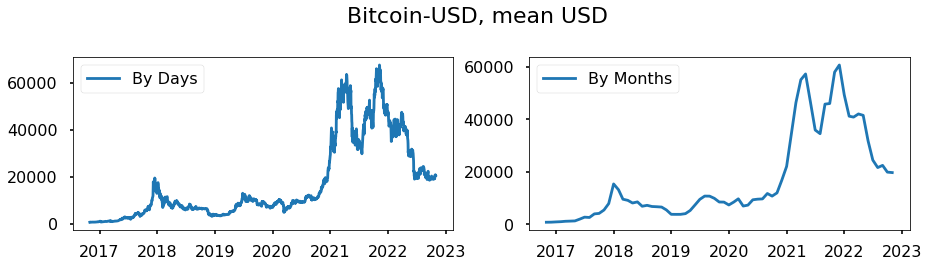

In [7]:
# Plots
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin-USD, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_m, '-', label='By Months')
plt.legend()
plt.show()

Dickey–Fuller test: p=0.485929


<Figure size 1080x504 with 0 Axes>

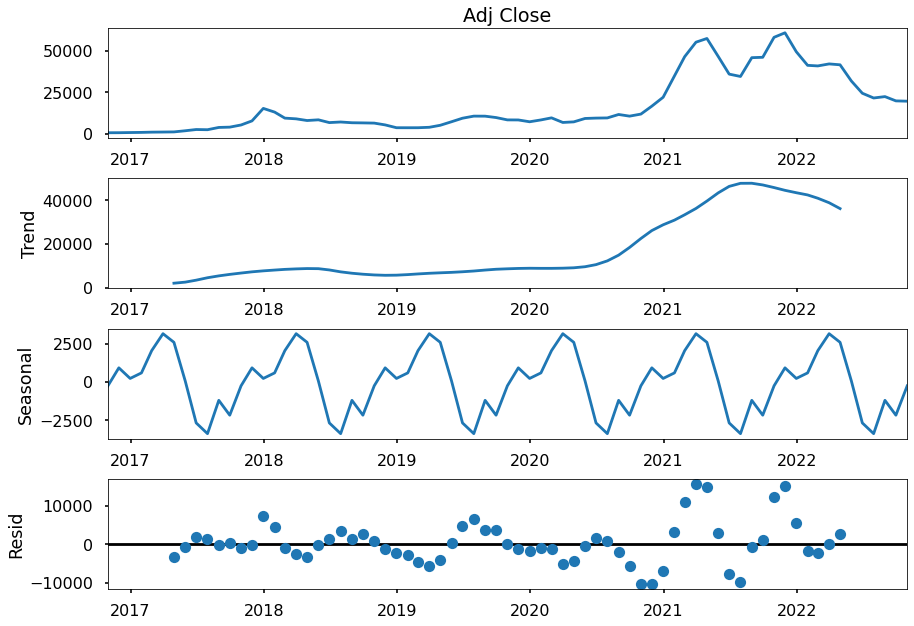

In [8]:
# Checking for stationarity 
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_m).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df_m)[1])
plt.show()

In [9]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

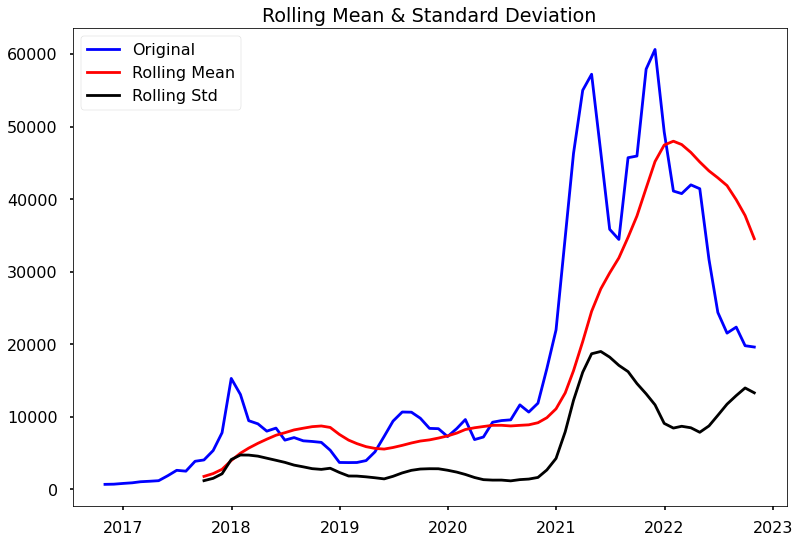

Results of Dickey-Fuller Test:
Test Statistic                 -1.595349
p-value                         0.485929
#Lags Used                      2.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [10]:
test_stationarity(df_m)

In [11]:
df_m

Date
2016-10-31      700.971985
2016-11-30      726.349101
2016-12-31      828.060356
2017-01-31      914.916159
2017-02-28     1062.533672
                  ...     
2022-06-30    24383.685482
2022-07-31    21539.253843
2022-08-31    22366.266318
2022-09-30    19804.779232
2022-10-31    19622.350716
Freq: M, Name: Adj Close, Length: 73, dtype: float64

The results indicate that the monthly adjusted prices are not stationary since it exihibts trends, seasonality, and changing covariance over time. Hence, the data is correlated and time series models cannot be built on top of it. We will need to transform the data and make it stationary first. 

In [12]:
# Box-Cox transformation
df_m = df_m.to_frame()
df_m = df_m.rename({'Adj Close': 'Adj_Close'}, axis='columns')

In [13]:
df_m['Adj_Close_Box'], lmbda = stats.boxcox(df_m['Adj_Close'])
print("Dickey–Fuller test: p=%f" % adfuller(df_m['Adj_Close_Box'])[1])

Dickey–Fuller test: p=0.249887


A Box Cox transformation process transforms non-normal dependent variables into a normal shape since normality is an important assumption. After the transformation, the sereis are still not stationary.

In [14]:
# Seasonal differentiation transformation
df_m['Adj_Close_sDiff'] = df_m.Adj_Close_Box - df_m.Adj_Close_Box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(df_m.Adj_Close_sDiff[12:])[1])

Dickey–Fuller test: p=0.238586


The p-value indicates that the series is still not stationary. Since the series also exhibit seasonality, we also want to conduct seasonal differentiation to further remove seasonality of the series. 

Dickey–Fuller test: p=0.000341


<Figure size 1080x504 with 0 Axes>

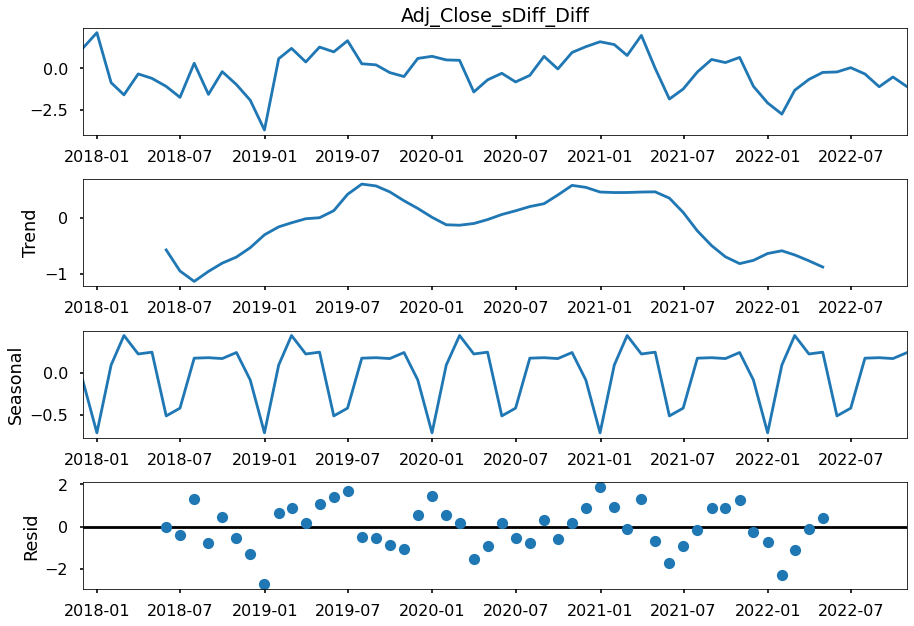

In [15]:
#Regular differentiation
df_m['Adj_Close_sDiff_Diff'] = df_m.Adj_Close_sDiff - df_m.Adj_Close_sDiff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_m.Adj_Close_sDiff_Diff[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(df_m.Adj_Close_sDiff_Diff[13:])[1])

plt.show()

Since the series also exhibit trend, we want to conduct regular differentiation to remove the trend in the series. After this step, the series is stationary according to the small p-value. Also, the trend mean is close to 0, so is the mean of seasonal component shown in the plot. We can now proceed to model selection to build a model describing the series and potentially predict the future adjusted prices of Bitcoin. 

Text(0.5, 1.0, 'Plot for ACF and PACF')

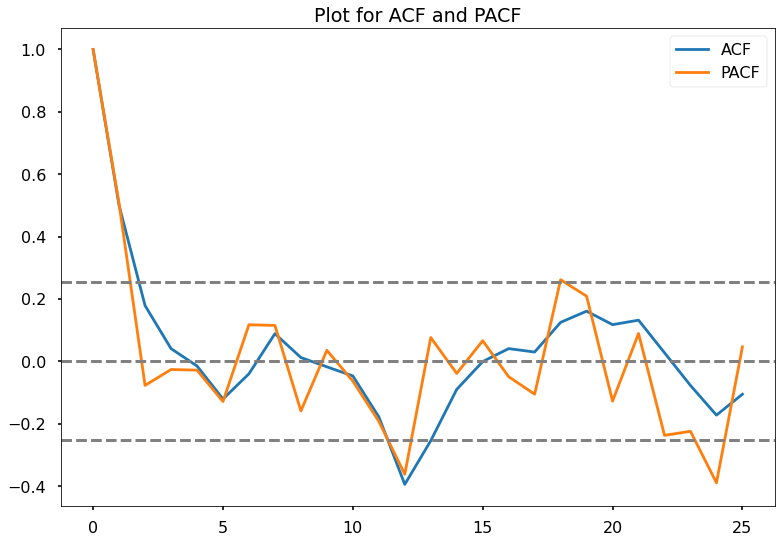

In [16]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_m.Adj_Close_sDiff_Diff[13:], nlags = 25)
lag_pacf = pacf(df_m.Adj_Close_sDiff_Diff[13:], nlags = 25, method = 'ols')

plt.plot(lag_acf, label = 'ACF')
plt.axhline(y = 0,linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(df_m.Adj_Close_sDiff_Diff[13:])),linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(df_m.Adj_Close_sDiff_Diff[13:])),linestyle = '--', color = 'gray')
plt.legend()

plt.plot(lag_pacf, label = 'PACF')
plt.axhline(y = 0,linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(df_m.Adj_Close_sDiff_Diff[13:])),linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(df_m.Adj_Close_sDiff_Diff[13:])),linestyle = '--', color = 'gray')
plt.legend()
plt.title('Plot for ACF and PACF')

The acf and pacf of the transformed series drop to 0 after lag 1. 

In [17]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_m.Adj_Close_Box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    # Calculate AIC as a performance metric to select the best model
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [18]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  158.947125
22  (1, 0, 2, 0)  159.281314
23  (1, 0, 2, 1)  160.223374
7   (0, 1, 0, 1)  160.414572
37  (2, 0, 0, 1)  160.559438
                                      SARIMAX Results                                       
Dep. Variable:                        Adj_Close_Box   No. Observations:                   73
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -76.474
Date:                              Thu, 02 Jan 2025   AIC                            158.947
Time:                                      10:32:27   BIC                            165.230
Sample:                                  10-31-2016   HQIC                           161.405
                                       - 10-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Among the best models, we would select the one with the least AIC, which is SARIMA(1,0,0,1) in this case. 

Dickey–Fuller test:: p=0.000000


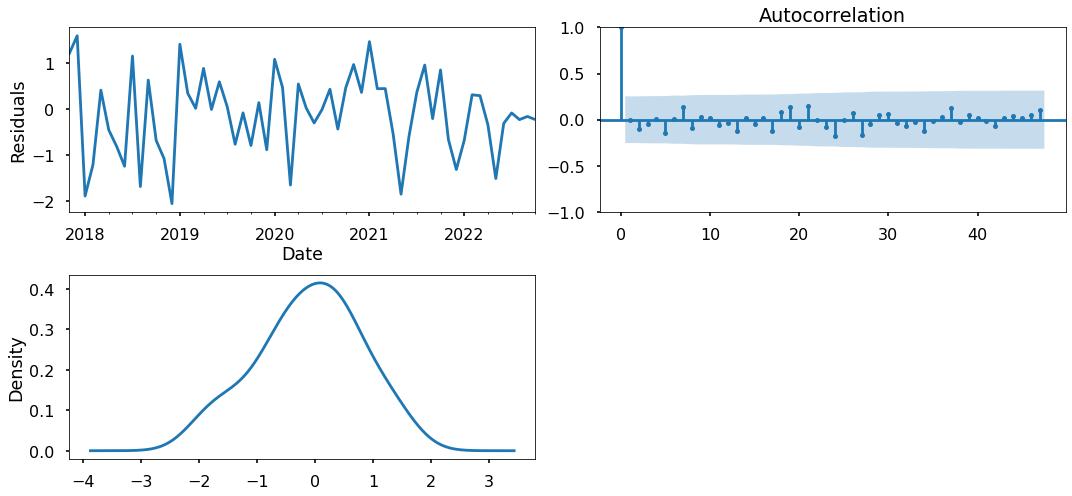

In [19]:
# Analysis of residuals 
plt.figure(figsize=(15,7))
plt.subplot(221)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(222)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=47, ax=ax)
plt.subplot(223)
best_model.resid[13:].plot(kind='kde')
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

The model residuals are around mean 0 and of constant variances of 1. The residual acf are 0 after lag 0. The distribution of the residual is close to that of normal.

In [20]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In this last step we want to predict for the near future performance of Bitcoin.

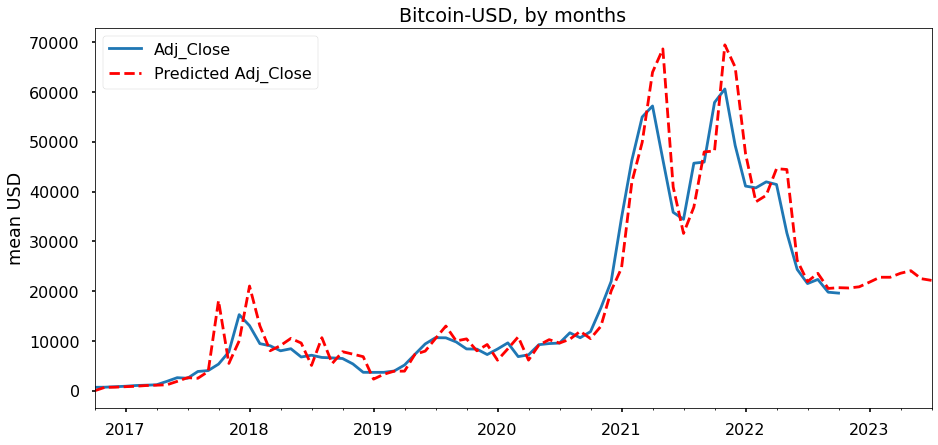

In [21]:
# Prediction 
df_m2 = df_m[['Adj_Close']]
date_list = [datetime(2022, 11, 30), datetime(2022, 12, 31), datetime(2023, 1, 31), datetime(2023, 2, 28), 
             datetime(2023, 3, 31), datetime(2023, 4, 30), datetime(2023, 5, 31), datetime(2023, 6, 30),
             datetime(2023, 7, 31)]
future = pd.DataFrame(index=date_list, columns= df_m.columns)
df_m2 = pd.concat([df_m2, future])
df_m2['forecast'] = invboxcox(best_model.predict(start=0, end=110), lmbda)
plt.figure(figsize=(15,7))
df_m2['Adj_Close'].plot()
df_m2['forecast'].plot(color='r', ls='--', label='Predicted Adj_Close')
plt.legend()
plt.title('Bitcoin-USD, by months')
plt.ylabel('mean USD')
plt.show()

In [22]:
df_m2['forecast']

2016-10-31        1.000000
2016-11-30      700.972902
2016-12-31      726.349559
2017-01-31      828.060662
2017-02-28      914.916369
                  ...     
2023-03-31    22805.497069
2023-04-30    23608.153916
2023-05-31    24113.613185
2023-06-30    22517.376002
2023-07-31    22173.794901
Name: forecast, Length: 82, dtype: float64

## Conclusions and Findings

Key findings from the analysis:
- Analyzed 6 years of Bitcoin price data from 2016 to 2022
- Observed significant price volatility and trends
- Performed statistical tests for stationarity and seasonality
- Developed time series models for understanding price patterns

### Future Work
- Incorporate additional features (trading volume, market sentiment)
- Experiment with different modeling approaches
- Extend the analysis to other cryptocurrencies